Total dataset size: 36
Training dataset size: 28
Validation dataset size: 8
Number of batches in validation dataset: -2
Validation dataset is empty.
Total dataset size: 36
Training dataset size (0.8 * Total): 28
Validation dataset size (Total - Training size): 8
2/2 [==============================] - 5s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
History keys: ['loss', 'accuracy']

Detailed Training History:
Epoch 1:
    loss: 0.0
    accuracy: 1.0

History keys: dict_keys(['loss', 'accuracy'])
History values:
loss: [0.0]
accuracy: [1.0]


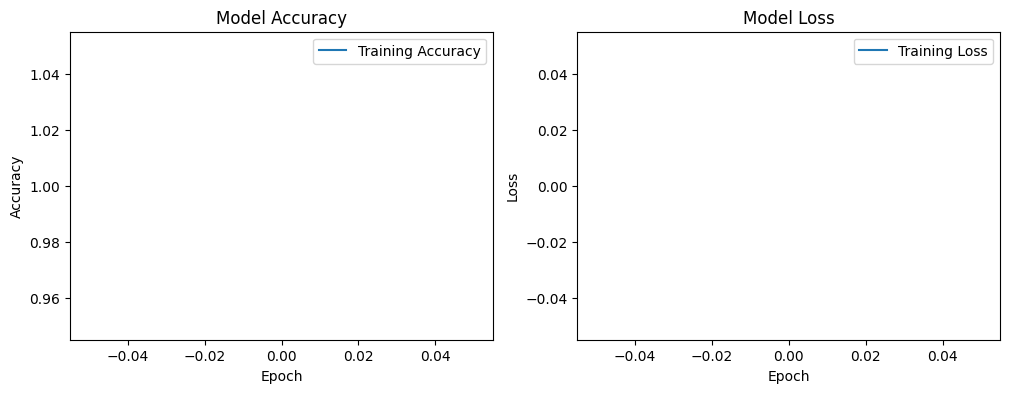

Copying file:///tmp/Emotion_Detection_AI_20240803_050444_v1.h5 [Content-Type=application/x-hdf5]...
\ [1 files][148.1 MiB/148.1 MiB]                                                
Operation completed over 1 objects/148.1 MiB.                                    


Model saved successfully to gs://storage_for_all/models/


Copying gs://storage_for_all/models/Emotion_Detection_AI_20240803_040927_v1.h5...
\ [1 files][148.1 MiB/148.1 MiB]                                                
Operation completed over 1 objects/148.1 MiB.                                    


Model loaded successfully from gs://storage_for_all/models/Emotion_Detection_AI_20240803_040927_v1.h5
Model loaded into TensorFlow


ValueError: not enough values to unpack (expected 2, got 0)

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import datetime


# Load CSV data
csv_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/data.csv'
df = pd.read_csv(csv_path)
df = df.drop(df.columns[0], axis=1)

df = df.loc[:35]# Adjust this part to ensure correct path handling:

# Adjust paths
df['path'] = df['path'].apply(lambda x: f"gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/dataset/{x.split('/')[-2]}/{x.split('/')[-1]}")

# Label encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['label'])
one_hot_encoded_labels = to_categorical(integer_encoded)

# Dataset preparation function
def load_image(file_path, label):
    """Load and preprocess images from file paths."""
    try:
        image_data = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])  # Resize as needed
        return image, label
    except tf.errors.NotFoundError:
        print(f"Failed to load image at: {file_path}")
        return None, label  # Handle missing files gracefully

# Create TensorFlow datasets
full_dataset = tf.data.Dataset.from_tensor_slices((df['path'].tolist(), one_hot_encoded_labels))
full_dataset = full_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
full_dataset = full_dataset.filter(lambda x, y: x is not None and y is not None)
full_dataset = full_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Split dataset into training and validation
dataset_size = len(df)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# train_dataset = full_dataset.take(train_size)
# val_dataset = full_dataset.skip(train_size).take(val_size)
train_dataset = full_dataset.take(train_size)
# val_dataset = full_dataset.skip(train_size).take(val_size)

train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size  # Ensure this is not zero

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

print("Total dataset size:", dataset_size)
print("Training dataset size:", train_size)
print("Validation dataset size:", val_size)

val_batch_count = val_dataset.cardinality().numpy()
print("Number of batches in validation dataset:", val_batch_count)

if val_batch_count > 0:
    for images, labels in val_dataset:
        print("Images batch shape:", images.shape)
        print("Labels batch shape:", labels.shape)
        break  # Break after the first complete batch
else:
    print("Validation dataset is empty.")

print(f"Total dataset size: {dataset_size}")
print(f"Training dataset size (0.8 * Total): {train_size}")
print(f"Validation dataset size (Total - Training size): {val_size}")


for images, labels in val_dataset.take(1):  # Take the first batch from the validation dataset
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    # Show the first image and label as an example
    if images.shape[0] > 0:  # Check if there are any images in the batch
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Sample Label: {labels[0].numpy()}")
        plt.axis('off')
        plt.show()



    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

# # Get the first 5 rows of the validation dataset
# val_dataset_subset = val_dataset.take(5)

# # Print the subset
# for batch in val_dataset_subset.as_numpy_iterator():
#     print(batch)

# Model definition
def tf_model(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model name and local path
model_name = f"Emotion_Detection_AI_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_v1.h5"
local_model_path = f"/tmp/{model_name}"

# Create a new directory for models if it doesn't exist
model_name=""
model_dir = "gs://storage_for_all/models"
full_model_path = f"{model_dir}/{model_name}"

num_classes = len(label_encoder.classes_)  # Number of unique classes
model = tf_model(num_classes)

# Model training
history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=val_dataset,
    use_multiprocessing=False,
    workers=1
)

# Print out the keys and values in history
print("History keys:", list(history.history.keys()))
print("\nDetailed Training History:")

# Iterate through each epoch
for i, values in enumerate(zip(*history.history.values())):
    epoch_data = f"Epoch {i+1}:\n"
    # Iterate over each metric
    for key, value in zip(history.history.keys(), values):
        epoch_data += f"    {key}: {value}\n"
    print(epoch_data)


# Print out the keys and values in history
print("History keys:", history.history.keys())
print("History values:")
for key, values in history.history.items():
    print(f"{key}: {values}")

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)




# Save the model locally
model.save(local_model_path, save_format='h5')

# Copy the model to Google Cloud Storage
gcs_model_path = f"gs://storage_for_all/models/{model_name}"
os.system(f"gsutil cp {local_model_path} {gcs_model_path}")

# Verify the model was copied
if tf.io.gfile.exists(gcs_model_path):
    print(f"Model saved successfully to {gcs_model_path}")
else:
    print("Failed to save the model to GCS")

    
# Define the model name and GCS path
model_name = "Emotion_Detection_AI_20240803_040927_v1.h5"  # Replace with your actual model name
gcs_model_path = f"gs://storage_for_all/models/{model_name}"
local_model_path = f"/tmp/{model_name}"

# Copy the model from GCS to local path
os.system(f"gsutil cp {gcs_model_path} {local_model_path}")



# Verify the model was copied
if not tf.io.gfile.exists(local_model_path):
    print("Failed to load the model from GCS")
else:
    print(f"Model loaded successfully from {gcs_model_path}")

    # Load the model from local path
    model = tf.keras.models.load_model(local_model_path)
    print("Model loaded into TensorFlow")

    # Evaluate the model
    #test_loss, test_acc = model.evaluate(val_dataset, verbose=0)  # Set verbose to 0 to disable progress bar
    #print("Test accuracy:", test_acc)
    test_loss, test_acc = model.evaluate(val_dataset, verbose=0)
    print("Test accuracy:", test_acc)

    # Function to predict emotion and display the image
    def predict_emotion(image_path):
        image_data = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.expand_dims(image, 0)  # Make batch of 1

        predictions = model.predict(image)
        predicted_class = np.argmax(predictions[0])
        emotion_label = label_encoder.inverse_transform([predicted_class])[0]

        # Display the image with the predicted emotion
        plt.figure(figsize=(4, 4))
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.title(f"Predicted Emotion: {emotion_label}")
        plt.axis('off')
        plt.show()

        return emotion_label

    # Example usage    
    image_path = 'gs://storage_for_all/DataSets/FacialEmotionRecognitionImageDataset_v1/dataset/Surprise/1bd930d6a1c717c11be33db74823f661cb53f86cbba1d3d1f336cdf9~12fffff.jpg'
    predicted_emotion = predict_emotion(image_path)
    print("Predicted Emotion:", predicted_emotion)
